In [4]:
# This is the (cleaned up) code accompanying the publication
#
# Pascal Welke, Fouad Alkhoury, Christian Bauckhage, Stefan Wrobel: Decision Snippet Features.
# International Conference on Pattern Recognition (ICPR) 2021.
#
# Code was written by Pascal Welke and Fouad Alkhoury and is based on
# code written by Sebastian Buschjäger (TU Dortmund) that is used for 
# json-serialization of random forest models.


# %% imports

import os
import json
import subprocess
import pickle

from sklearn.utils.estimator_checks import check_estimator
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline

import ReadData
import cString2json as cString2json
import json2graphNoLeafEdgesWithSplitValues as json2graphNoLeafEdgesWithSplitValues
from fitModels import fitModels
import DecisionSnippetFeatures as DecisionSnippetFeatures
import pruning
import Forest
import datetime
from util import writeToReport
import numpy as np
# %% Parameters.
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

dataPath = "../data/"
forestsPath = "../tmp/forests/"
snippetsPath = "../tmp/snippets/"
resultsPath = "../tmp/results/"
reportsPath = "../tmp/reports/"

# current valid options are ['sensorless', 'satlog', 'mnist', 'magic', 'spambase', 'letter', 'bank', 'adult', 'drinking']
dataSet = 'satlog'
# dataSet = 'adult'
# dataSet = 'drinking'

# possible forest_types ['RF', 'DT', 'ET']
forest_types = ['RF']
forest_depths = [2]
sigma_values = [0.0,0.1,0.2,0.3]
#forest_depths = [5, 10, 15, 20]
forest_size = 25

maxPatternSize = 2
minThreshold = 2
maxThreshold = 25

scoring_function = 'accuracy'

# learners that are to be used on top of Decision Snippet Features
learners = {'DSF_NB': MultinomialNB,
            'DSF_SVM': LinearSVC, 
            'DSF_LR': LogisticRegression}

# specify parameters that are given at initialization
learners_parameters = {'DSF_NB': {},
                       'DSF_SVM': {'max_iter': 10000},
                       'DSF_LR': {'max_iter': 1000}}


# for quick debugging, let the whole thing run once. Afterwards, you may deactivate individual steps
# each step stores its output for the subsequent step(s) to process
run_fit_models = True
run_mining = False
run_training = True
run_eval = True

verbose = True

fitting_models_time = datetime.timedelta()
pruning_time = datetime.timedelta()



# %% load data

X_train, Y_train = ReadData.readData(dataSet, 'train', dataPath)
X_test, Y_test = ReadData.readData(dataSet, 'test', dataPath)
#print(len(X_train))
#print(len(X_test))
X = X_train

# %% create forest data, evaluate and report accuracy on test data
start_fitting_models = datetime.datetime.now()

if run_fit_models:
    print('\n\nHERE ARE THE ACCURACIES ON TEST DATA OF THE ORIGINAL RANDOM FORESTS\n(don\'t worry, test data is not used for training)\n')

    fitModels(roundSplit=True, 
              XTrain=X_train, YTrain=Y_train, 
              XTest=X_test, YTest=Y_test, 
              createTest=False, model_dir=os.path.join(forestsPath, dataSet), types=forest_types, forest_depths = forest_depths)

end_fitting_models = datetime.datetime.now()
fitting_models_time = (end_fitting_models- start_fitting_models)

print('Fitting Models Time: '+str(fitting_models_time))    
# Pruning
report_model_dir = reportsPath+'/'+dataSet 
report_file = report_model_dir + '/report.txt'
if not os.path.exists(report_model_dir):
    os.makedirs(report_model_dir)
        
writeToReport(report_file,'Fitting Models Time \t ' + str(fitting_models_time) + '\n')

start_pruning_total = datetime.datetime.now()
writeToReport(report_file,'Pruning Time \t ')
writeToReport(report_file,'RF \t Sigma \t Pruning Time')

'''
for depth in forest_depths:
    
    input_file = forestsPath+dataSet+'/RF_'+ str(depth) +'.json'
    #feature_vectors_file = X
    
    
    f = Forest.Forest()
    f.fromJSON(input_file)
    t = f.trees[0]
    
    feature_vectors = X

    for sigma in sigma_values:
        
        start_pruning = datetime.datetime.now()
        
        pruning.Min_DBN(feature_vectors, f, sigma)
        pruning.post_processing(f)
        #print(f.pstr())
    
        #save the pruned forest in a json file
        sigma_as_string = '_'.join(str(sigma).split('.'))
        output_file = forestsPath + dataSet + '/RF_'+ str(depth) +'_pruned_with_sigma_' + sigma_as_string + '.json'
    
        with open(output_file, 'w') as outfile:
            outfile.write(f.str())
            
        end_pruning = datetime.datetime.now()
        pruning_time = (end_pruning - start_pruning)
        print('Pruning Time for RF_'+str(depth)+' and sigma='+str(sigma)+' : '+str(pruning_time)) 
        writeToReport(report_file, str(depth)+ '\t ' +str(sigma)+ '\t \t' + str(pruning_time))
    
end_pruning_total = datetime.datetime.now()
pruning_total_time = (end_pruning_total - start_pruning_total)

print('Total Pruning Time: '+str(pruning_total_time))  
writeToReport(report_file, 'Total Pruning Time: '+str(pruning_total_time) + '\n')
'''
# %% compute decision snippets


start_mining_total = datetime.datetime.now()

writeToReport(report_file,'Mining Time \t ')

if run_mining:
    print('\n\nFEEL FREE TO IGNORE THIS OUTPUT\n')

    def pattern_frequency_filter(f_patterns, frequency, f_filtered_patterns):
        pattern_count = 0
        for line in f_patterns:
            tokens = line.split('\t')
            if int(tokens[0]) >= frequency:
                f_filtered_patterns.write(line)
                pattern_count += 1
        return pattern_count

    start_json_to_graph = datetime.datetime.now()
    # translate json to graph files
    for json_file in filter(lambda x: x.endswith('.json'), os.listdir(os.path.join(forestsPath, dataSet))):
        #print(json_file[:-4])
        graph_file = json_file[:-4] + 'graph'
        with open(os.path.join(forestsPath, dataSet, json_file), 'r') as f_in:
            with open(os.path.join(forestsPath, dataSet, graph_file), 'w') as f_out:
                json2graphNoLeafEdgesWithSplitValues.main(f_in, f_out)

    end_json_to_graph = datetime.datetime.now()
    json_to_graph_time = (end_json_to_graph - start_json_to_graph)
    print('Translating Time :' + str(json_to_graph_time)) 
    writeToReport(report_file, 'Translating Time :' + str(json_to_graph_time))    

    # run frequent pattern mining
    if not os.path.exists(os.path.join(snippetsPath, dataSet)):
        os.makedirs(os.path.join(snippetsPath, dataSet))

    for graph_file in filter(lambda x: x.endswith('.graph'), os.listdir(os.path.join(forestsPath, dataSet))):
        
        # pattern mining for smallest minThreshold
        #print(f"mining {minThreshold}-frequent patterns for {graph_file}")
        
        start_mining = datetime.datetime.now()
        print("mining "+ str(minThreshold) + " frequent patterns for " + str(graph_file))
        pattern_file=os.path.join(snippetsPath, dataSet, graph_file[:-6] + f'_t{minThreshold}.patterns')
        feature_file=os.path.join(snippetsPath, dataSet, graph_file[:-6] + f'_t{minThreshold}.features')
        log_file=os.path.join(snippetsPath, dataSet, graph_file[:-6] + f'_t{minThreshold}.logs')

        args = ['../lwgr', '-erootedTrees', '-mbfs', f'-t{minThreshold}', f'-p{maxPatternSize}', 
                f'-o{pattern_file}', os.path.join(forestsPath, dataSet, graph_file)]
        with open(feature_file, 'w') as f_out:
            with open(log_file, 'w') as f_err:        
                subprocess.run(args, stdout=f_out, stderr=f_err)

        # filtering of patterns for larger thresholds
        print(f"filtering more frequent patterns for {graph_file}")
        for threshold in range(maxThreshold, minThreshold, -1):
            filtered_pattern_file=os.path.join(snippetsPath, dataSet, graph_file[:-6] + f'_t{threshold}.patterns')
            pattern_count = -1
            with open(pattern_file, 'r') as f_patterns:
                with open(filtered_pattern_file, 'w') as f_filtered_patterns:
                    pattern_count = pattern_frequency_filter(f_patterns, threshold, f_filtered_patterns)
            
            # if there are no frequent patterns for given threshold, remove the file.
            if pattern_count == 0:
                os.remove(filtered_pattern_file)
            else:
                if verbose:
                    print(f'threshold {threshold}: {pattern_count} frequent patterns')


        # transform canonical string format to json
        for threshold in range(maxThreshold, minThreshold-1, -1):
            filtered_pattern_file = os.path.join(snippetsPath, dataSet, graph_file[:-6] + f'_t{threshold}.patterns')
            filtered_json_file = os.path.join(snippetsPath, dataSet, graph_file[:-6] + f'_t{threshold}.json')
            try:
                with open(filtered_pattern_file, 'r') as f_filtered_patterns:
                    with open(filtered_json_file, 'w') as f_filtered_json:
                        json_data = cString2json.parseCStringFileUpToSizePatterns(f_filtered_patterns, patternSize=maxPatternSize)
                        f_filtered_json.write(json_data)
            except EnvironmentError:
                # this might happen if a certain threshold resulted in no frequent patterns and is OK
                pass
            
            
        end_mining = datetime.datetime.now()
        mining_time = (end_mining - start_mining)
        print('Mining Time for '+ graph_file +' : '+str(mining_time)) 
        writeToReport(report_file, 'Mining Time for '+ graph_file +' : '+str(mining_time))    

end_mining_total = datetime.datetime.now()
mining_total_time = (end_mining_total - start_mining_total)
writeToReport(report_file, 'Total Mining Time: '+str(mining_total_time) + '\n')

# %% Training of classifiers. For later selection of best candidate learners, run xval on train to estimate generalization

writeToReport(report_file,'Training Time \t ')



f = open(snippetsPath+'/'+'satlog_'+'/'+'RF_5_t2'+'.json')
frequentpatterns = json.load(f)
f.close()



HERE ARE THE ACCURACIES ON TEST DATA OF THE ORIGINAL RANDOM FORESTS
(don't worry, test data is not used for training)

Fitting RF_2
Testing  RF_2
Total time: 0.009930767999321688 ms
Saving model
Accuracy: 0.6165
Saving model to PKL on disk
*** Summary ***
#Examples	 #Features	 Accuracy	 Avg.Tree Height
0.6165	2.3333333333333344

Fitting Models Time: 0:00:00.106240


In [7]:
print(len(frequentpatterns))
fts = frequentpatterns

46


In [8]:
        class_labels_list = ''
        class_labels_list_P = ''

        one_counter=0
        zero_counter=0
        max_id = 0
        max_class_id = 0
        trees_count = len(fts[0])

        for i in range(0,len(fts)):
            if (Y_train[i] > max_class_id):
                max_class_id +=1


            for j in range(0,len(fts[i])):
                if (fts[i][j] > max_id):
                    max_id = fts[i][j]
                  
        id_count= max_id + 1            
        class_count = max_class_id + 1  

        for i in range(0,class_count):
            class_labels_list += 'Y = '+str(i)+','
            class_labels_list_P += 'P(Y) = '+str(i)+','
    
            
          
        

        Matrix = np.zeros((trees_count,id_count,class_count))


        for i in range(0,len(fts)):
            for j in range(0,trees_count):

                     Matrix[j][fts[i][j]][Y_train[i]] +=1

                            
 


        
        Prefered_Class_Matrix = np.zeros((trees_count,id_count))
        Prefered_Class_Matrix_P = np.zeros((trees_count,id_count,class_count))
        f= open(resultsPath+'/'+dataset+'/Details_Files/'+'DSF_as_RF_'+str(rf_depth)+'_t'+str(frequency)+'_'+dataset+'_n.csv',"w")
        f.write('Feature ,Leaf id,'+class_labels_list+' Preferred Class, '+class_labels_list_P+'\n')
        for j in range(0,trees_count):
            for k in range(0,id_count):
                f.write(str(j)+','+str(k)+',')
                for c in range(0,class_count):
                        f.write(str(Matrix[j][k][c])+',')
                Prefered_Class_Matrix[j][k] = np.argmax(Matrix[j][k])       
                f.write(str(np.argmax(Matrix[j][k]))+',')  
                for c in range(0,class_count):
                    if (np.sum(Matrix[j][k]) != 0):
                        f.write(str(round(Matrix[j][k][c]/np.sum(Matrix[j][k]),3))+',')
                        Prefered_Class_Matrix_P[j][k][c] = round(Matrix[j][k][c]/np.sum(Matrix[j][k]),3)
                    else:
                        f.write('0,')
                f.write('\n')    

        f.close()            
        
        
        fts_test = dsf.fit_transform(X_test,0)



        labels_array = [0] * class_count
        labels_array_p = [0] * class_count
        predictedClass = 0
        correctPredictions = 0
        predictedClass_p = 0
        correctPredictions_p = 0

        for i in range(0,len(fts_test)):
            labels_array = [0] * class_count
            for j in range(0,trees_count):
                for c in range(0,class_count):

                    if (Prefered_Class_Matrix[j][fts_test[i][j]] == c):
                        labels_array[c] += 1

                        labels_array_p[c] += Prefered_Class_Matrix_P[j][fts_test[i][j]][c] 

            predictedClass =np.argmax(labels_array)
            predictedClass_p =np.argmax(labels_array_p)

            if (predictedClass == Y_test[i]):
                correctPredictions += 1
            labels_array = [0] * class_count
            if (predictedClass_p == Y_test[i]):
                correctPredictions_p += 1
            labels_array_p = [0] * class_count

        print(correctPredictions)
        
        print(correctPredictions/len(fts_test))
        predictions_results_majority_vote.append(correctPredictions/len(fts_test))
        predictions_results_average_probability.append(correctPredictions_p/len(fts_test))
        
        if (correctPredictions/len(fts_test) > best_prediction_majority_vote):
            best_prediction_majority_vote = correctPredictions/len(fts_test)
            best_prediction_majority_vote_dsf = 'RF_'+str(rf_depth)+'_t'+str(frequency)
            
        if (correctPredictions_p/len(fts_test) > best_prediction_average_probability):
            best_prediction_average_probability = correctPredictions_p/len(fts_test)
            best_prediction_average_probability_dsf = 'RF_'+str(rf_depth)+'_t'+str(frequency)    
        
        

KeyError: 0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

from sklearn.datasets import load_digits

In [2]:
dataset = load_digits()
X = dataset['data']
y = dataset['target']

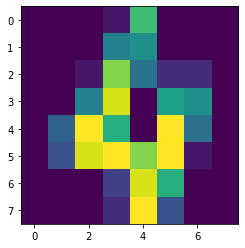

In [3]:
plt.imshow(X[4].reshape(8,8))

In [4]:
reg_ada = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1))
scores_ada = cross_val_score(reg_ada, X, y, cv=6)
scores_ada.mean()

0.2615310293571163